In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils
from analyze_fits import analyze_gabor_params

import copy
import cmocean


from utils import prf_utils,numpy_utils
import scipy.stats
import pandas as pd

import numpy as np
from utils import circ_utils
from feature_extraction import gabor_feature_extractor


#### info about gabor feature space 

In [2]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Load things

In [3]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type1 = 'gabor_solo_ridge_12ori_8sf'
out1 = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type1, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]
fitting_type2 = 'gabor_solo_ridge_12ori_8sf_from_residuals'
out2= [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type2, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]
fig_save_folder=None

roi_def = roi_utils.multi_subject_roi_def(subjects, \
                                          remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

In [162]:
roi_def.print_overlap()

V1: 15016 vox total
V2: 12742 vox total
V3: 11298 vox total
hV4: 3886 vox total
V3ab: 3716 vox total
IPS: 14847 vox total
OPA: 10693 vox total
PPA: 8546 vox total
RSC: 6139 vox total
OFA: 4047 vox total
FFA: 7119 vox total
EBA: 25860 vox total


In [4]:
[o['residuals_model_name'] for o in out2]

['all_coco',
 'all_coco',
 'all_coco',
 'all_coco',
 'all_coco',
 'all_coco',
 'all_coco',
 'all_coco']

In [5]:
[o['average_image_reps'] for o in out2]

[True, True, True, True, True, True, True, True]

In [6]:
[o['average_image_reps'] for o in out1]

[True, True, True, True, True, True, True, True]

In [7]:
[o['saved_prfs_fn'] for o in out1]

['/user_data/mmhender/imStat/model_fits/S01/alexnet_all_conv_pca/Apr-01-2022_1317_39/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S02/alexnet_all_conv_pca/Apr-02-2022_2104_46/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S03/alexnet_all_conv_pca/Apr-04-2022_0349_08/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S04/alexnet_all_conv_pca/Apr-05-2022_1052_06/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S05/alexnet_all_conv_pca/Apr-07-2022_1401_20/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S06/alexnet_all_conv_pca/Apr-10-2022_1650_18/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S07/alexnet_all_conv_pca/Apr-11-2022_2255_10/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S08/alexnet_all_conv_pca/Apr-13-2022_0045_36/all_fit_params.npy']

In [8]:
[o['saved_prfs_fn'] for o in out2]

['/user_data/mmhender/imStat/model_fits/S01/alexnet_all_conv_pca/Apr-01-2022_1317_39/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S02/alexnet_all_conv_pca/Apr-02-2022_2104_46/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S03/alexnet_all_conv_pca/Apr-04-2022_0349_08/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S04/alexnet_all_conv_pca/Apr-05-2022_1052_06/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S05/alexnet_all_conv_pca/Apr-07-2022_1401_20/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S06/alexnet_all_conv_pca/Apr-10-2022_1650_18/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S07/alexnet_all_conv_pca/Apr-11-2022_2255_10/all_fit_params.npy',
 '/user_data/mmhender/imStat/model_fits/S08/alexnet_all_conv_pca/Apr-13-2022_0045_36/all_fit_params.npy']

#### organize feature selectivity matrices

In [5]:
feature_corr1 = np.concatenate([out1[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr1.shape[0]
allcorr_reshaped1 = np.reshape(feature_corr1, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr1 = np.mean(allcorr_reshaped1, axis=2)
mean_sf_corr1 = np.mean(allcorr_reshaped1, axis=1)

# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr1 = np.argmax(mean_orient_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_orient_corr1[:,0:1], [1,n_ori])==mean_orient_corr1, axis=1)
preferred_ori_corr1[is_constant1] = np.nan

preferred_sf_corr1 = np.argmax(mean_sf_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_sf_corr1[:,0:1], [1,n_sf])==mean_sf_corr1, axis=1)
preferred_sf_corr1[is_constant1] = np.nan

feature_corr2 = np.concatenate([out2[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr2.shape[0]
allcorr_reshaped2 = np.reshape(feature_corr2, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr2 = np.mean(allcorr_reshaped2, axis=2)
mean_sf_corr2 = np.mean(allcorr_reshaped2, axis=1)

# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr2 = np.argmax(mean_orient_corr2, axis=1).astype(np.float32)
is_constant2 = np.all(np.tile(mean_orient_corr2[:,0:1], [1,n_ori])==mean_orient_corr2, axis=1)
preferred_ori_corr2[is_constant2] = np.nan

preferred_sf_corr2 = np.argmax(mean_sf_corr2, axis=1).astype(np.float32)
is_constant2 = np.all(np.tile(mean_sf_corr2[:,0:1], [1,n_sf])==mean_sf_corr2, axis=1)
preferred_sf_corr2[is_constant2] = np.nan

#### threshold voxels by R2
make sure it is always the same set of voxels when comparing across models. 
have to pass threshold for both.

In [6]:
r2_cutoff = 0.01
val_r2_1 = np.concatenate([out1[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
val_r2_2 = np.concatenate([out2[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = (val_r2_1>r2_cutoff) & (val_r2_2>r2_cutoff)

#### how many voxels were left after thresholding?

In [7]:
n_vox_each_subj = [out1[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

thresh_sizes = np.zeros((n_subjects, n_rois),dtype=int)
orig_sizes = np.zeros((n_subjects, n_rois),dtype=int)
for ss in range(n_subjects):
    for rr in range(n_rois):
        orig_sizes[ss,rr] = np.sum(roi_def.get_indices(rr) \
                                     & (subject_inds==ss))
        thresh_sizes[ss,rr] = np.sum(roi_def.get_indices(rr) \
                                     & abv_thresh \
                                     & (subject_inds==ss))
        

In [20]:
pd.DataFrame(orig_sizes, index=subjects, columns=roi_names)

,V1,V2,V3,hV4,V3ab,IPS,OPA,PPA,RSC,OFA,FFA,EBA
1,2392,2096,1632,568,497,1921,1611,1033,566,355,794,2798
2,1630,1496,1467,447,555,2036,1380,994,813,441,869,3195
3,2275,1732,1412,362,656,2117,1330,1251,838,701,1093,3237
4,1526,1297,1139,380,332,2131,1235,960,813,602,942,2889
5,1705,1433,1219,506,358,1532,1332,1221,771,782,907,4050
6,1771,1719,1799,788,373,1792,1362,1229,845,519,826,4005
7,1926,1475,1275,418,586,1452,1083,912,694,316,484,2785
8,1791,1494,1355,417,359,1866,1360,946,799,331,1204,2901


In [171]:
pd.DataFrame(thresh_sizes, index=subjects, columns=roi_names)

,V1,V2,V3,hV4,V3ab,IPS,OPA,PPA,RSC,OFA,FFA,EBA
1,1547,1372,1183,421,204,125,460,222,74,219,263,736
2,1092,878,965,353,200,206,531,408,296,246,386,638
3,1243,986,796,216,176,55,82,151,71,304,156,345
4,797,747,559,157,79,16,198,179,194,176,149,135
5,1078,887,685,288,151,121,430,459,76,366,136,493
6,1123,1025,858,384,78,80,228,179,20,166,79,291
7,1062,838,516,255,37,86,314,129,13,113,98,313
8,767,681,519,227,15,11,78,77,7,95,277,191


#### for each voxel, how correlated are the estimates of its tuning from two methods?

In [8]:
corr_between_methods = np.array([np.corrcoef(feature_corr1[vv,:], feature_corr2[vv,:])[0,1] \
                                 for vv in range(n_voxels)])

avg_corr_bw_methods = np.zeros((n_rois, n_subjects))
for rr in range(n_rois):
    for ss in range(n_subjects):
        inds_this_roi = roi_def.get_indices(rr) & abv_thresh & (subject_inds==ss)
        avg_corr_bw_methods[rr,ss] = np.mean(corr_between_methods[inds_this_roi])

#### Plot histograms of similarity in feature selectivity, across methods

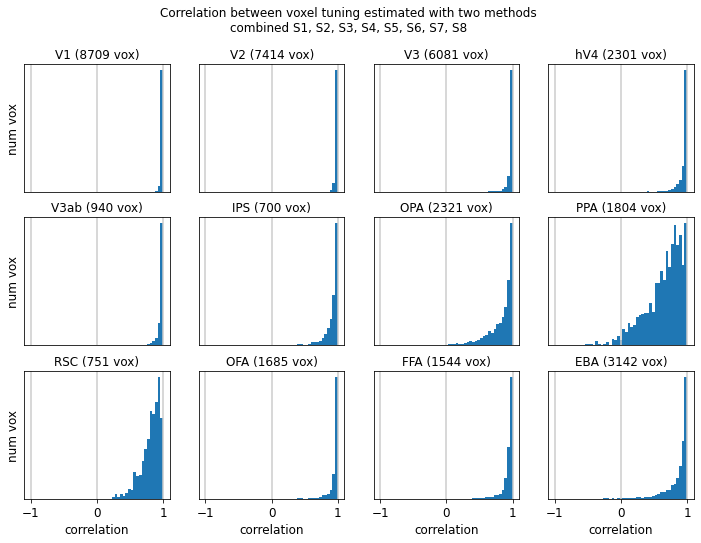

In [173]:
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(12,8))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    bins = np.linspace(-1,1,50)
    plt.hist(corr_between_methods[inds_this_roi],bins=bins)
    plt.xlim([-1.1, 1.1])
    plt.axvline(1.0, color=[0.8, 0.8, 0.8])
    plt.axvline(-0.0, color=[0.8, 0.8, 0.8])
    plt.axvline(-1.0, color=[0.8, 0.8, 0.8])
    if np.mod(pi, npy)==1:
        plt.ylabel('num vox')
    plt.yticks([])
    if pi>=(npx-1)*npy+1:
        plt.xlabel('correlation')
    else:
        plt.xticks([]);

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

plt.suptitle('Correlation between voxel tuning estimated with two methods\n%s'\
             %(summary_plots.get_substr(out1)));

#### simpler summary plot of these correlations

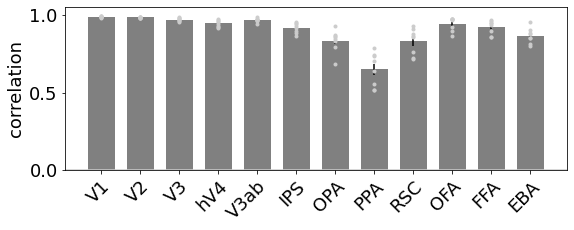

In [205]:
mean_vals = np.mean(avg_corr_bw_methods, axis=1, keepdims=True)
sem_vals = np.std(avg_corr_bw_methods, axis=1, keepdims=True)/np.sqrt(n_subjects)

plt.rcParams['pdf.fonttype']=42
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=avg_corr_bw_methods.T[:,:,np.newaxis], 
                                space=0.15, \
                xticklabels=roi_names, ylabel='correlation', \
                ylim=[0.0, 1.05], title='',\
                fig_size=(9,3), \
                colors=np.array([[0.5, 0.5, 0.5]]))

fn2save = '/user_data/mmhender/imStat/figures/Similarity_featuretuning_raw_vs_resid.pdf'
plt.savefig(fn2save)

#### how much did performance drop when regressing out coco-all features?

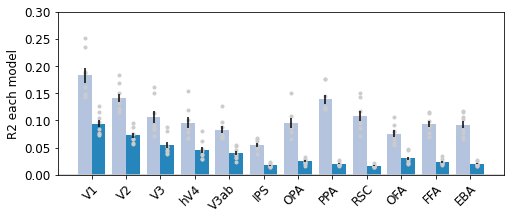

In [31]:
# drop in performance expressed as percentage of original
# r2_drop = (val_r2_1 - val_r2_2)/val_r2_1
from utils import nsd_utils
nc = np.concatenate([nsd_utils.ncsnr_to_nc(out1[si]['voxel_ncsnr']\
                    [out1[si]['voxel_mask']])/100 for si in range(n_subjects)], axis=0)
nc_thresh = 0.01

avg_r2 = np.zeros((n_subjects, n_rois, 2))
for rr in range(n_rois):
    for ss in range(n_subjects):
        inds_this_roi = roi_def.get_indices(rr) & abv_thresh & (subject_inds==ss)
        # inds_this_roi = roi_def.get_indices(rr) & (nc>nc_thresh) & (subject_inds==ss)
        avg_r2[ss,rr,0] = np.mean(val_r2_1[inds_this_roi])
        avg_r2[ss,rr,1] = np.mean(val_r2_2[inds_this_roi])

mean_vals = np.mean(avg_r2, axis=0)
sem_vals = np.std(avg_r2, axis=0)/np.sqrt(n_subjects)


colors = cm.PuBu(np.linspace(0,1,4))[1:,:]
# colors = cm.RdPu(np.linspace(0,1,4))[2:4,:]
plt.rcParams['pdf.fonttype']=42
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=avg_r2, 
                                space=0.1, \
                xticklabels=roi_names, ylabel='R2 each model', \
                ylim=[0.0,0.3], title='',\
                colors=colors,\
                fig_size=(8,3))

fn2save = '/user_data/mmhender/imStat/figures/R2_compare_raw_vs_resid.pdf'
plt.savefig(fn2save)

In [25]:
avg_r2.shape

(8, 12, 2)

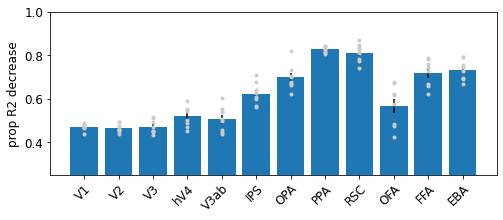

In [156]:
# drop in performance expressed as percentage of original
r2_drop = (val_r2_1 - val_r2_2)/val_r2_1

avg_drop_bw_methods = np.zeros((n_rois, n_subjects))
for rr in range(n_rois):
    for ss in range(n_subjects):
        inds_this_roi = roi_def.get_indices(rr) & abv_thresh & (subject_inds==ss)
        avg_drop_bw_methods[rr,ss] = np.mean(r2_drop[inds_this_roi])

mean_vals = np.mean(avg_drop_bw_methods, axis=1, keepdims=True)
sem_vals = np.std(avg_drop_bw_methods, axis=1, keepdims=True)/np.sqrt(n_subjects)

plt.rcParams['pdf.fonttype']=42
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=avg_drop_bw_methods.T[:,:,np.newaxis], 
                                space=0.1, \
                xticklabels=roi_names, ylabel='prop R2 decrease', \
                ylim=[0.25,1], title='',\
                
                fig_size=(8,3))

fn2save = '/user_data/mmhender/imStat/figures/R2_drop_raw_vs_resid.pdf'
plt.savefig(fn2save)

#### direct comparison of performance for full model/residuals model

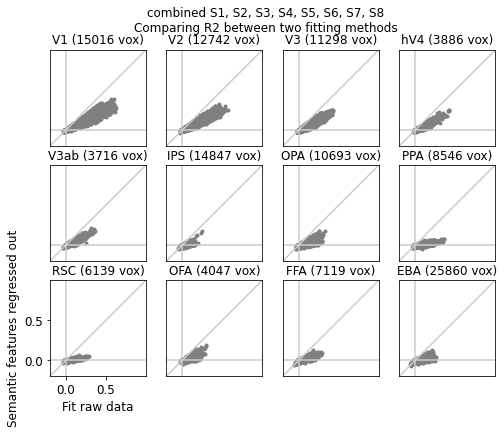

In [103]:
dat = np.array([val_r2_1, val_r2_2]).T
inds2use = np.ones((n_voxels,),dtype=bool)

sp = plot_utils.scatter_plot(color=np.array([[0.5, 0.5, 0.5]]), \
                             xlabel='Fit raw data', \
                             ylabel='Semantic features regressed out', \
                             xlims=[-0.2, 1.0], ylims=[-0.2, 1.0], \
                  xticks=[0, 0.5], yticks=[0, 0.5],\
                  show_diagonal=True, show_axes=True);

plot_utils.create_roi_subplots(dat, inds2use, sp, \
                    suptitle='%s\nComparing R2 between two fitting methods'%summary_plots.get_substr(out1), \
                   label_just_corner=True, figsize=(8,6),roi_def=roi_def)

In [32]:
# stuff for plots

roi_groups = [[0,1,2,3],[4,5],[6,7,8],[9,10],[11]]
n_roi_groups = len(roi_groups)
# colors = np.tile([[0.6, 0.6, 0.6],],[5,1])
colors = ['#7f7f7f', '#7f7f7f', '#7f7f7f', '#7f7f7f', '#7f7f7f']
# colors = ['#0071bc',  '#f15a24', '#006837', '#c1272d', '#662d91']
roi_color_inds = [np.where([ri in rg for rg in roi_groups])[0][0] for ri in range(n_rois)]


### Violin plots - orientation selectivity

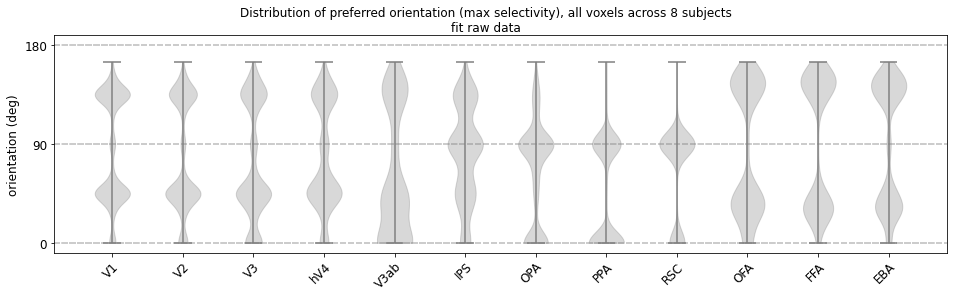

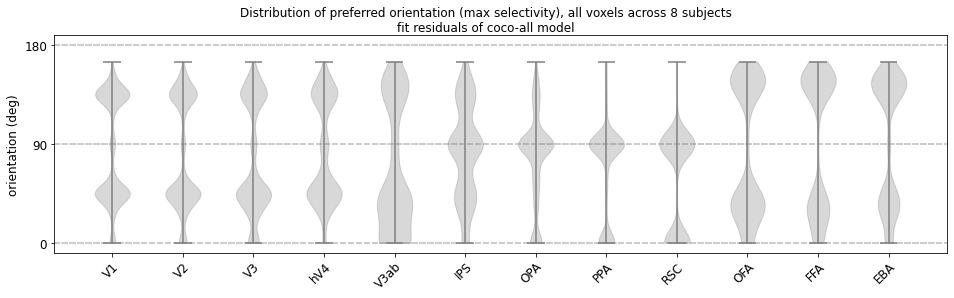

In [13]:
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

names = ['fit raw data', 'fit residuals of coco-all model']

pi=0
for corrs, name in zip([preferred_ori_corr1, preferred_ori_corr2], names):

    plt.figure(figsize=(16,4))

    for ri in range(n_rois):
        
        color = colors[roi_color_inds[ri]]

        inds_this_roi = roi_def.get_indices(ri) & abv_thresh

        parts = plt.violinplot(ori_unique[corrs[inds_this_roi].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)

        plt.yticks([0,90,180])
        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

        plt.ylabel('orientation (deg)')

        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                           rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('Distribution of preferred orientation (max selectivity), all voxels across 8 subjects\n%s'%name)


/user_data/mmhender/imStat/figures/PPA_raw_vs_resid.pdf


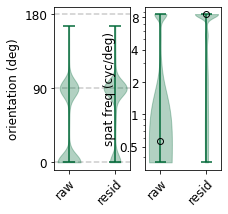

In [19]:
rr = 7;
color = colors[roi_color_inds[rr]]
ti = 1;

names = ['raw', 'resid']
   
inds_this_roi = roi_def.get_indices(rr) & abv_thresh
                                                    
plt.figure(figsize=(3,3))

plt.subplot(1,2,1);

for ti, corrs in enumerate([preferred_ori_corr1, preferred_ori_corr2]):

    parts = plt.violinplot(ori_unique[corrs[inds_this_roi].astype(int)],[ti])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
plt.ylabel('orientation (deg)')
plt.yticks([0,90,180]);

plt.xticks(ticks=np.arange(0,2),\
                       labels=names,\
                       rotation=45, ha='right',rotation_mode='anchor');

plt.subplot(1,2,2);

for ti, corrs in enumerate([preferred_sf_corr1, preferred_sf_corr2]):

    vals = sf_unique[corrs[inds_this_roi].astype(int)]
    parts = plt.violinplot(vals,[ti])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)
    plt.plot(ti, np.median(vals),'o',color='k',markerfacecolor='none')

plt.yticks([0,4,8])

plt.ylabel('spat freq (cyc/deg)')
plt.gca().set_yscale('log')
plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])

plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)


plt.xticks(ticks=np.arange(0,2),\
                       labels=names,\
                       rotation=45, ha='right',rotation_mode='anchor');

fn2save = '/user_data/mmhender/imStat/figures/%s_raw_vs_resid.pdf'%(roi_names[rr])
print(fn2save)
plt.savefig(fn2save)


In [187]:
color

'#006837'

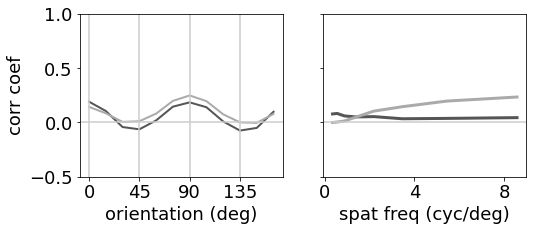

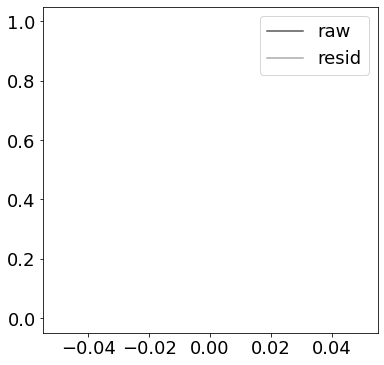

In [190]:
# Plot average orientation tuning curves for each ROI

rr=7;
names = ['raw', 'resid']

colors = cm.gray(np.linspace(0,1,4))[1:3,:]


plot_utils.set_all_font_sizes(18)

# indices for the voxels of interest
inds_this_roi = roi_def.get_indices(rr) & abv_thresh


plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
for ti, meancorrs in enumerate([mean_orient_corr1, mean_orient_corr2]):

    plt.plot(ori_unique,  np.mean(meancorrs[inds_this_roi], axis=0),\
             '-',color=colors[ti,:],linewidth=2)

plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.ylim([-0.5, 1.0])

plt.xlabel('orientation (deg)')
plt.ylabel('corr coef')
plt.xticks(np.arange(0,180,45))

for ii in np.arange(0,180,45):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])

plt.subplot(1,2,2)
for ti, meancorrs in enumerate([mean_sf_corr1, mean_sf_corr2]):

    plt.plot(sf_unique,  np.mean(meancorrs[inds_this_roi], axis=0),\
                 '-',color=colors[ti,:],linewidth=3)

plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.ylim([-0.5,1])
plt.xticks([0,4,8])
plt.yticks([-0.5, 0, 0.5, 1], labels=[])
plt.xlabel('spat freq (cyc/deg)')
# plt.ylabel('corr coef')

# fn2save = '/user_data/mmhender/imStat/figures/Profiles_%s_sep_%s.pdf'%(roi_names[rr], groupname)
# print(fn2save)
# plt.savefig(fn2save)

# plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,6));
for ti, meancorrs in enumerate([mean_orient_corr1, mean_orient_corr2]):
    plt.plot(0,ti,color=colors[ti,:])    
    plt.legend(names)


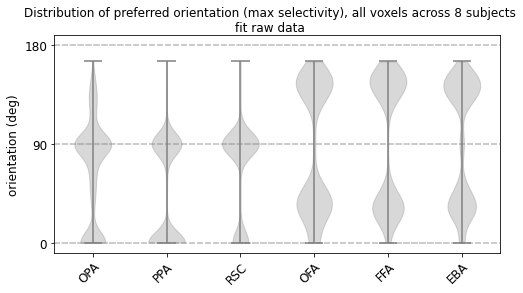

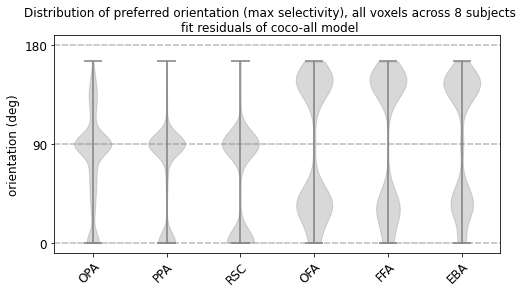

In [33]:
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

names = ['fit raw data', 'fit residuals of coco-all model']

rois2plot = [6,7,8,9,10,11]

pi=0
for corrs, name in zip([preferred_ori_corr1, preferred_ori_corr2], names):

    plt.figure(figsize=(8,4))

    for ri, rr in enumerate(rois2plot):
        
        color = colors[roi_color_inds[rr]]

        inds_this_roi = roi_def.get_indices(rr) & abv_thresh

        parts = plt.violinplot(ori_unique[corrs[inds_this_roi].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)

        plt.yticks([0,90,180])
        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

        plt.ylabel('orientation (deg)')

        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,len(rois2plot)),\
                           labels=np.array(roi_names)[rois2plot],\
                           rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('Distribution of preferred orientation (max selectivity), all voxels across 8 subjects\n%s'%name)

    pi+=1
    fn2save = '/user_data/mmhender/imStat/figures/Orient_violins_semresiduals_%d.pdf'%pi
    plt.savefig(fn2save)

In [127]:
color

2

### Violin plots - frequency selectivity

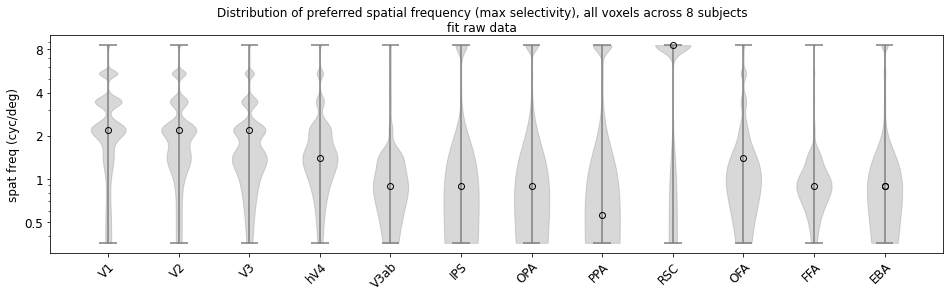

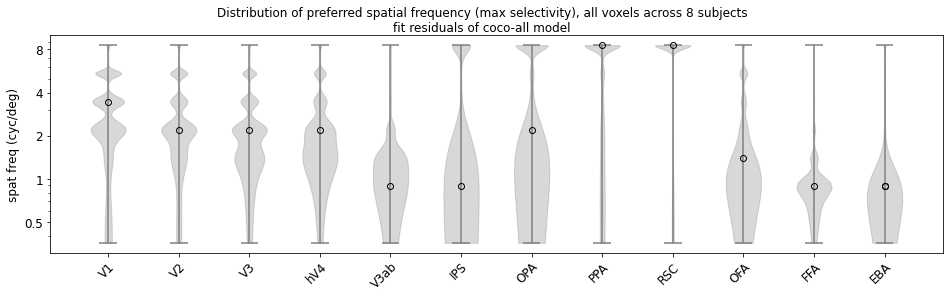

In [34]:

plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = [0.6, 0.6, 0.6]

names = ['fit raw data', 'fit residuals of coco-all model']

pi=0
for corrs, name in zip([preferred_sf_corr1, preferred_sf_corr2], names):

    plt.figure(figsize=(16,4))

    for ri in range(n_rois):

        color = colors[roi_color_inds[ri]]

        inds_this_roi = roi_def.get_indices(ri) & abv_thresh

        parts = plt.violinplot(sf_unique[corrs[inds_this_roi].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)
        
        plt.plot(ri, np.median(sf_unique[corrs[inds_this_roi].astype(int)]),\
             marker='o',color='k', markerfacecolor='none')

    plt.plot(ri, np.median(sf_unique[corrs[inds_this_roi].astype(int)]), 'o',\
            color='k', markerfacecolor='none')

    plt.yticks([0,4,8])

    plt.ylabel('spat freq (cyc/deg)')
    plt.gca().set_yscale('log')
    plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])

    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                           rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('Distribution of preferred spatial frequency (max selectivity), all voxels across 8 subjects\n%s'%name)


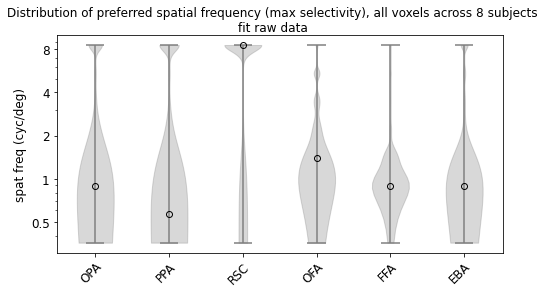

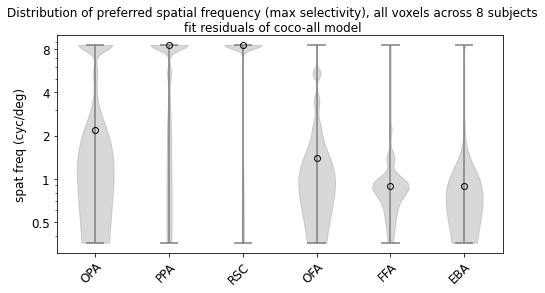

In [35]:

plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = [0.6, 0.6, 0.6]

names = ['fit raw data', 'fit residuals of coco-all model']

rois2plot = [6,7,8,9,10,11,]

pi=0
for corrs, name in zip([preferred_sf_corr1, preferred_sf_corr2], names):

    plt.figure(figsize=(8,4))

    for ri, rr in enumerate(rois2plot):

        color = colors[roi_color_inds[rr]]
        
        inds_this_roi = roi_def.get_indices(rr) & abv_thresh

        parts = plt.violinplot(sf_unique[corrs[inds_this_roi].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)
        
        plt.plot(ri, np.median(sf_unique[corrs[inds_this_roi].astype(int)]), 'o',\
                color='k', markerfacecolor='none')

        plt.yticks([0,4,8])

        plt.ylabel('spat freq (cyc/deg)')
        plt.gca().set_yscale('log')
        plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])
    
        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,len(rois2plot)),\
               labels=np.array(roi_names)[rois2plot],\
               rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('Distribution of preferred spatial frequency (max selectivity), all voxels across 8 subjects\n%s'%name)

    pi+=1
    fn2save = '/user_data/mmhender/imStat/figures/Freq_violins_semresiduals_%d.pdf'%pi
    plt.savefig(fn2save)

#### Orient distributions as histograms

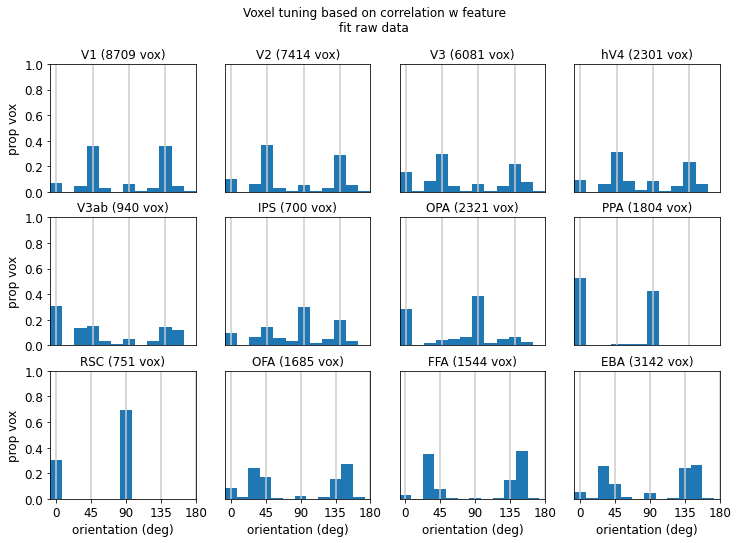

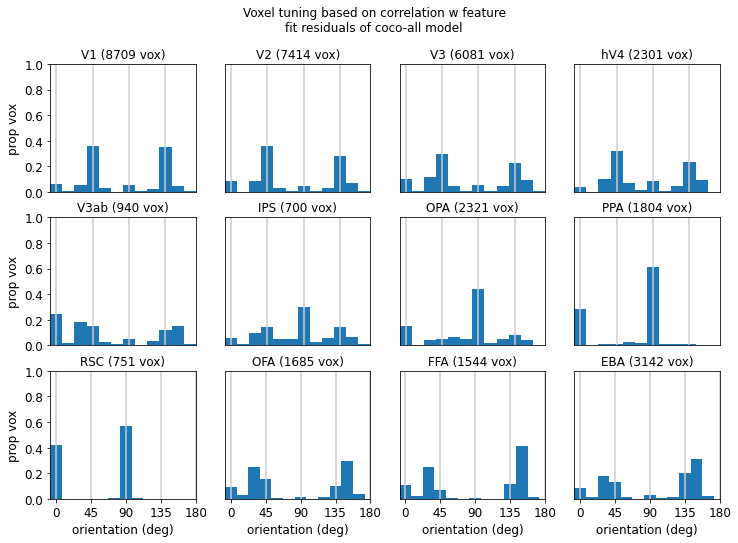

In [33]:
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

names = ['fit raw data', 'fit residuals of coco-all model']

for corrs, name in zip([preferred_ori_corr1, preferred_ori_corr2], names):


    plt.figure(figsize=(12,8))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    pi=0
    for ri in range(n_rois):

        inds_this_roi = roi_def.get_indices(ri) & abv_thresh

        pi+=1
        plt.subplot(npx,npy,pi)

        spacing = ori_unique[1] - ori_unique[0]
        neach = [np.sum(corrs[inds_this_roi]==oo) for oo in range(n_ori)]
        assert(np.sum(neach)==np.sum(inds_this_roi))
        propeach = neach/np.sum(inds_this_roi)
        plt.bar(ori_unique, propeach, width=spacing)

        plt.xlim([-spacing/2,180-spacing/2])
        plt.ylim([0, 1.0])
        if np.mod(pi, npy)==1:
            plt.ylabel('prop vox')
        else:
            plt.yticks([])

        if pi>=(npx-1)*npy+1:
            plt.xticks(np.arange(0,181,45))
            plt.xlabel('orientation (deg)')
        else:
            plt.xticks([]);

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])

        plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

    plt.suptitle('Voxel tuning based on correlation w feature\n%s'%name);

#### Frequency distributions as histograms

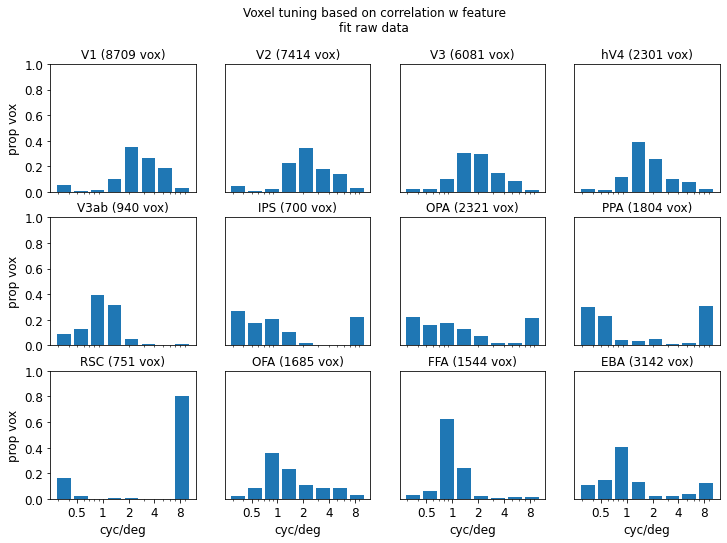

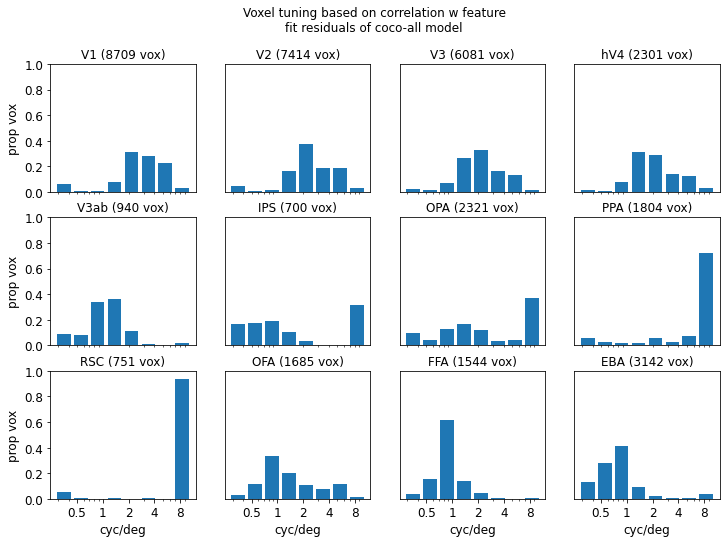

In [38]:

plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

names = ['fit raw data', 'fit residuals of coco-all model']

for corrs, name in zip([preferred_sf_corr1, preferred_sf_corr2], names):


    plt.figure(figsize=(12,8))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    pi=0
    for ri in range(n_rois):

        inds_this_roi = roi_def.get_indices(ri) & abv_thresh

        pi+=1
        plt.subplot(npx,npy,pi)

        spacing = np.diff(sf_unique)
        if len(spacing)>1:
            dlog = np.log(spacing[1]) - np.log(spacing[0])                
        else:
            dlog = np.log(sf_unique[1]) - np.log(sf_unique[0])
            plt.xlim([10**np.log10(0.1), 10**np.log10(14)])
        spacing = np.concatenate([[np.exp(np.log(spacing[0]) - dlog)], spacing])

        neach = [np.sum(corrs[inds_this_roi]==ff) for ff in range(n_sf)]
        assert(np.sum(neach)==np.sum(inds_this_roi))
        propeach = neach/np.sum(inds_this_roi)
        plt.bar(sf_unique, propeach, width=spacing)


        plt.gca().set_xscale('log')
        plt.ylim([0, 1.0])

        if np.mod(pi, npy)==1:
            plt.ylabel('prop vox')
        else:
            plt.yticks([])

        if pi>=(npx-1)*npy+1:
            plt.xlabel('cyc/deg')
            plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                        10**np.log10(2),10**np.log10(4), \
                        10**np.log10(8)],\
                       [0.5,1,2,4,8])
        else:
            plt.xticks([]);


        plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

    plt.suptitle('Voxel tuning based on correlation w feature\n%s'\
                 %(name));


#### Plot average orientation selectivity profiles for each ROI

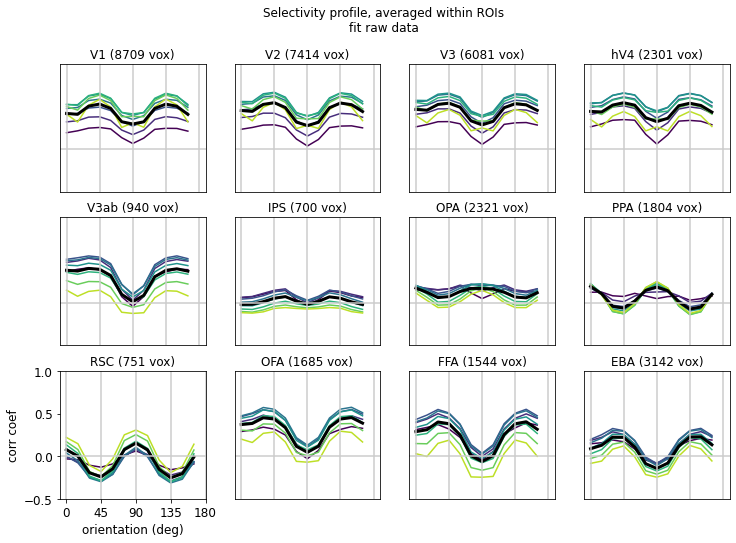

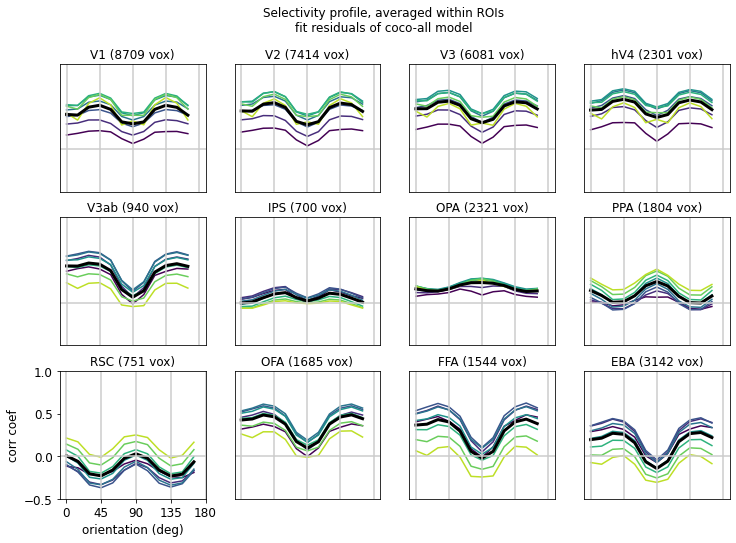

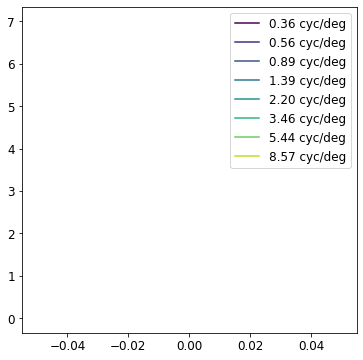

In [40]:
names = ['fit raw data', 'fit residuals of coco-all model']

for corrs, means, name in zip([allcorr_reshaped1, allcorr_reshaped2], \
                              [mean_orient_corr1, mean_orient_corr2], \
                              names):


    plt.figure(figsize=(12,8))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    colors = cm.viridis(np.linspace(0,0.9,n_sf))

    pi=0
    for rr in range(n_rois):

        inds_this_roi = roi_def.get_indices(rr) & abv_thresh

        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:
            for sf in range(n_sf):
                plt.plot(ori_unique, np.mean(corrs[inds_this_roi,:,sf], axis=0),\
                     '-',color=colors[sf,:])
            plt.plot(ori_unique,  np.mean(means[inds_this_roi,:], axis=0),\
                     '-',color='k',linewidth=3)

        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-0.5,1])

        if pi==(npx-1)*npy+1:
            plt.xlabel('orientation (deg)')
            plt.ylabel('corr coef')
            plt.xticks(np.arange(0,181,45))
        else:
            plt.xticks([]);
            plt.yticks([])

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])

        plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

    plt.suptitle('Selectivity profile, averaged within ROIs\n%s'%name)

plt.figure(figsize=(6,6));
for sf in range(n_sf):
    plt.plot(0,sf,color=colors[sf,:])    
plt.legend(['%.2f cyc/deg'%sf_unique[sf] for sf in range(n_sf)]);

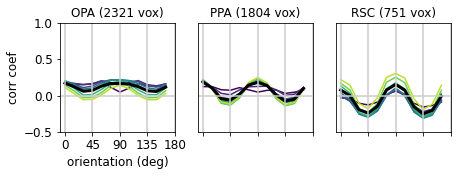

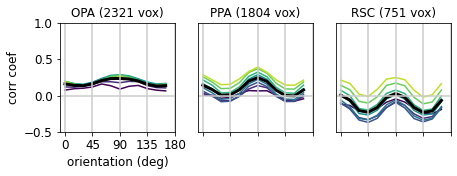

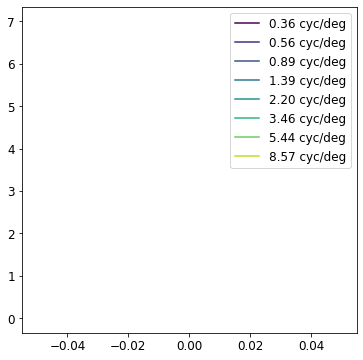

In [10]:
names = ['fit raw data', 'fit residuals of coco-all model']

rois2plot = [6,7,8]

ni=0
plt.rcParams['pdf.fonttype']=42

for corrs, means, name in zip([allcorr_reshaped1, allcorr_reshaped2], \
                              [mean_orient_corr1, mean_orient_corr2], \
                              names):


    plt.figure(figsize=(7,2))
    npy = 3
    npx = 1
    
    colors = cm.viridis(np.linspace(0,0.9,n_sf))

    pi=0
    for ri,rr in  enumerate(rois2plot):

        inds_this_roi = roi_def.get_indices(rr) & abv_thresh

        pi+=1
        
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:
            for sf in range(n_sf):
                plt.plot(ori_unique, np.mean(corrs[inds_this_roi,:,sf], axis=0),\
                     '-',color=colors[sf,:])
            plt.plot(ori_unique,  np.mean(means[inds_this_roi,:], axis=0),\
                     '-',color='k',linewidth=3)

        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-0.5,1])

        if pi==(npx-1)*npy+1:
            plt.xlabel('orientation (deg)')
            plt.ylabel('corr coef')
            plt.xticks(np.arange(0,181,45))
        else:
            plt.xticks(np.arange(0,181,45),labels=[])
            plt.yticks([])

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])

        plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

    ni+=1
    fn2save = '/user_data/mmhender/imStat/figures/Orient_profiles_sem_residuals_%d.pdf'%ni
    plt.savefig(fn2save)
    # plt.suptitle('Selectivity profile, averaged within ROIs\n%s'%name)

plt.figure(figsize=(6,6));
for sf in range(n_sf):
    plt.plot(0,sf,color=colors[sf,:])    
plt.legend(['%.2f cyc/deg'%sf_unique[sf] for sf in range(n_sf)]);

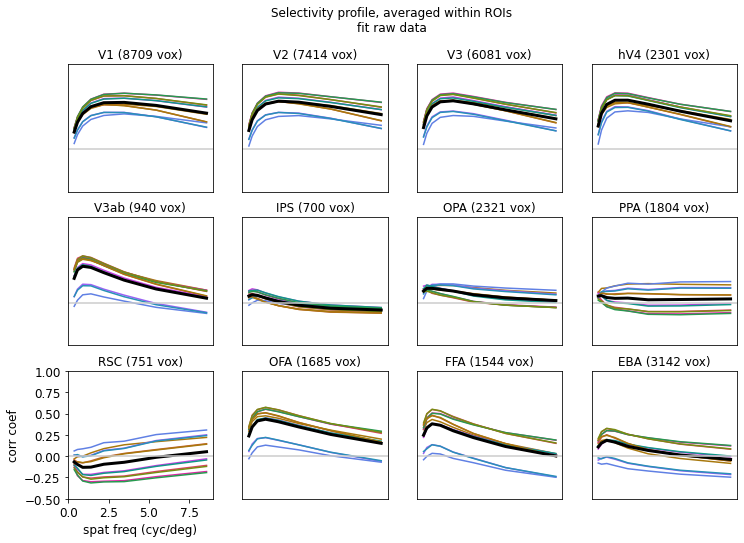

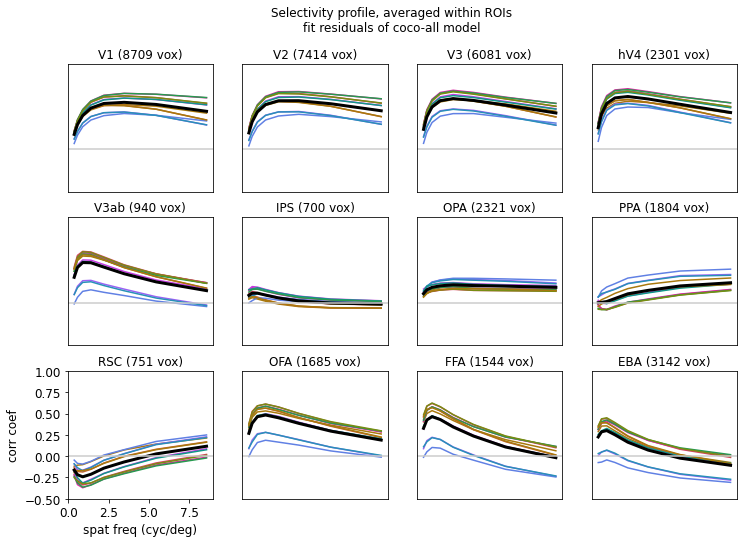

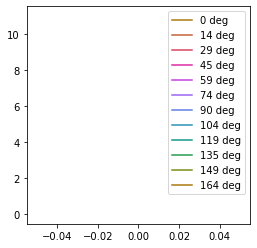

In [41]:
# Plot average spat freq tuning curves for each ROI

plot_utils.set_all_font_sizes(fs = 12)

names = ['fit raw data', 'fit residuals of coco-all model']

for corrs, means, name in zip([allcorr_reshaped1, allcorr_reshaped2], \
                              [mean_sf_corr1, mean_sf_corr2], \
                              names):

    plt.figure(figsize=(12,8))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    colors = cmocean.cm.phase(np.linspace(0,1,n_ori))

    pi=0
    for rr in range(n_rois):

        inds_this_roi = roi_def.get_indices(rr) & abv_thresh

        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:
            for oo in range(n_ori):
                plt.plot(sf_unique, np.mean(corrs[inds_this_roi,oo,:], axis=0).T,\
                     '-',color=colors[oo,:])
            plt.plot(sf_unique,  np.mean(means[inds_this_roi,:], axis=0),\
                     '-',color='k',linewidth=3)

        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-0.5,1])

        if pi==(npx-1)*npy+1:
            plt.xlabel('spat freq (cyc/deg)')
            plt.ylabel('corr coef')
        else:
            plt.xticks([]);
            plt.yticks([])

        plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

    plt.suptitle('Selectivity profile, averaged within ROIs\n%s'%name)

plot_utils.set_all_font_sizes(fs = 10)
plt.figure(figsize=(4,4));
for oo in range(n_ori):
    plt.plot(0,oo,color=colors[oo,:])    
plt.legend(['%d deg'%ori_unique[oo] for oo in range(n_ori)]);


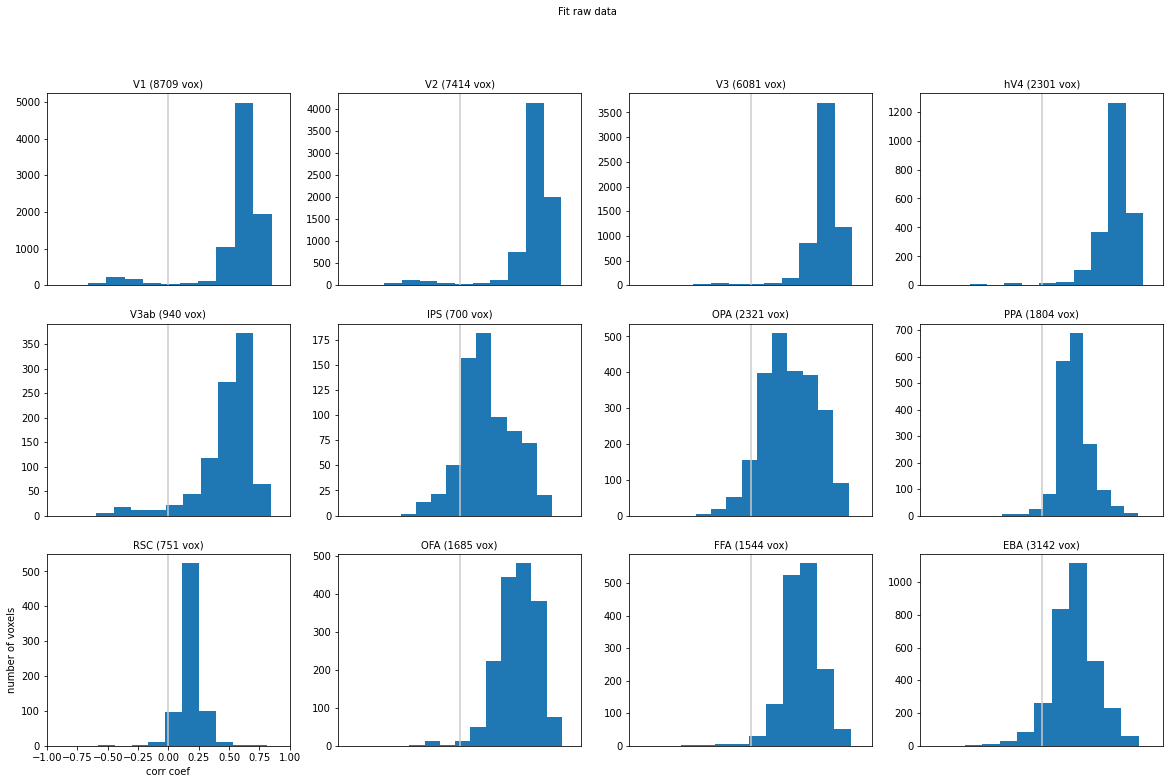

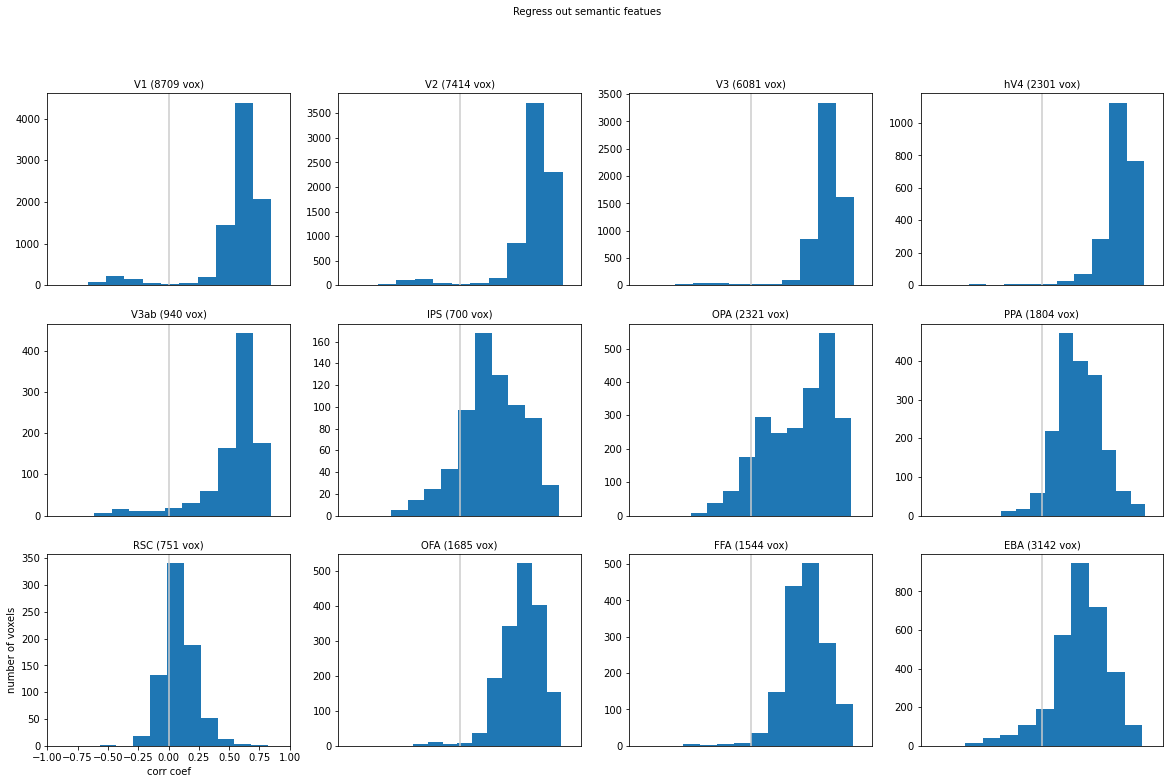

In [42]:
# plotting the distribution of voxel's maximum corr coef, for any orientation

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.max(mean_orient_corr1[inds_this_roi], axis=1)
    
    plt.hist(vals)
    plt.xlim([-1,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('corr coef')
        plt.ylabel('number of voxels')
    else:
        plt.xticks([]);

    plt.axvline(0,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

    plt.suptitle('Fit raw data')

    
plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.max(mean_orient_corr2[inds_this_roi], axis=1)
    
    plt.hist(vals)
    plt.xlim([-1,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('corr coef')
        plt.ylabel('number of voxels')
    else:
        plt.xticks([]);

    plt.axvline(0,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

    plt.suptitle('Regress out semantic featues')
    

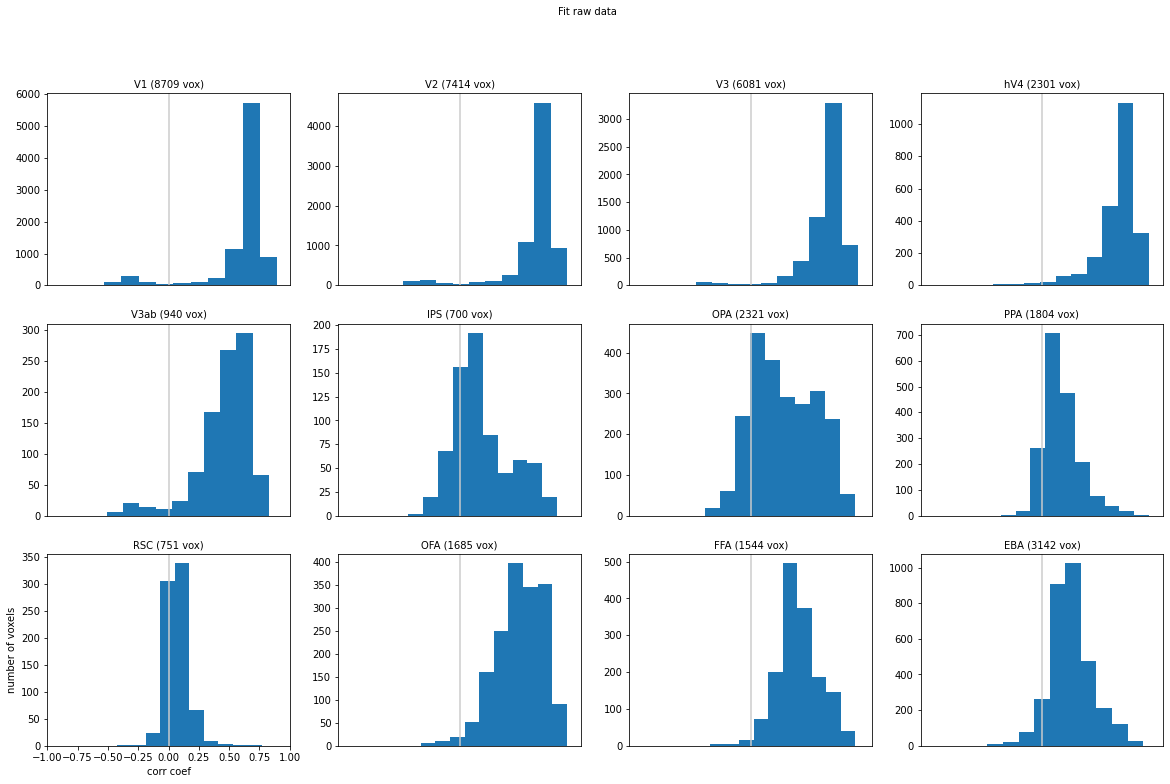

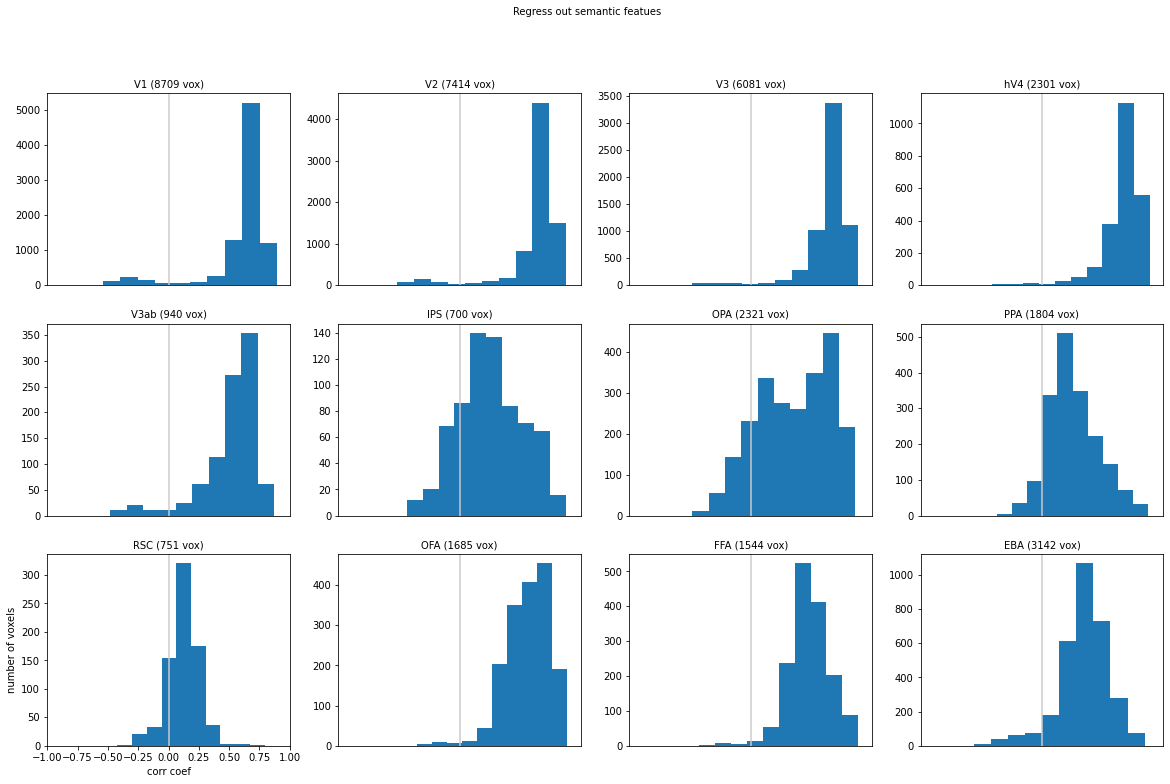

In [45]:
# plotting the distribution of voxel's maximum corr coef, for any freq

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.max(mean_sf_corr1[inds_this_roi], axis=1)
    
    plt.hist(vals)
    plt.xlim([-1,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('corr coef')
        plt.ylabel('number of voxels')
    else:
        plt.xticks([]);

    plt.axvline(0,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

    plt.suptitle('Fit raw data')

    
plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.max(mean_sf_corr2[inds_this_roi], axis=1)
    
    plt.hist(vals)
    plt.xlim([-1,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('corr coef')
        plt.ylabel('number of voxels')
    else:
        plt.xticks([]);

    plt.axvline(0,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

    plt.suptitle('Regress out semantic featues')
    

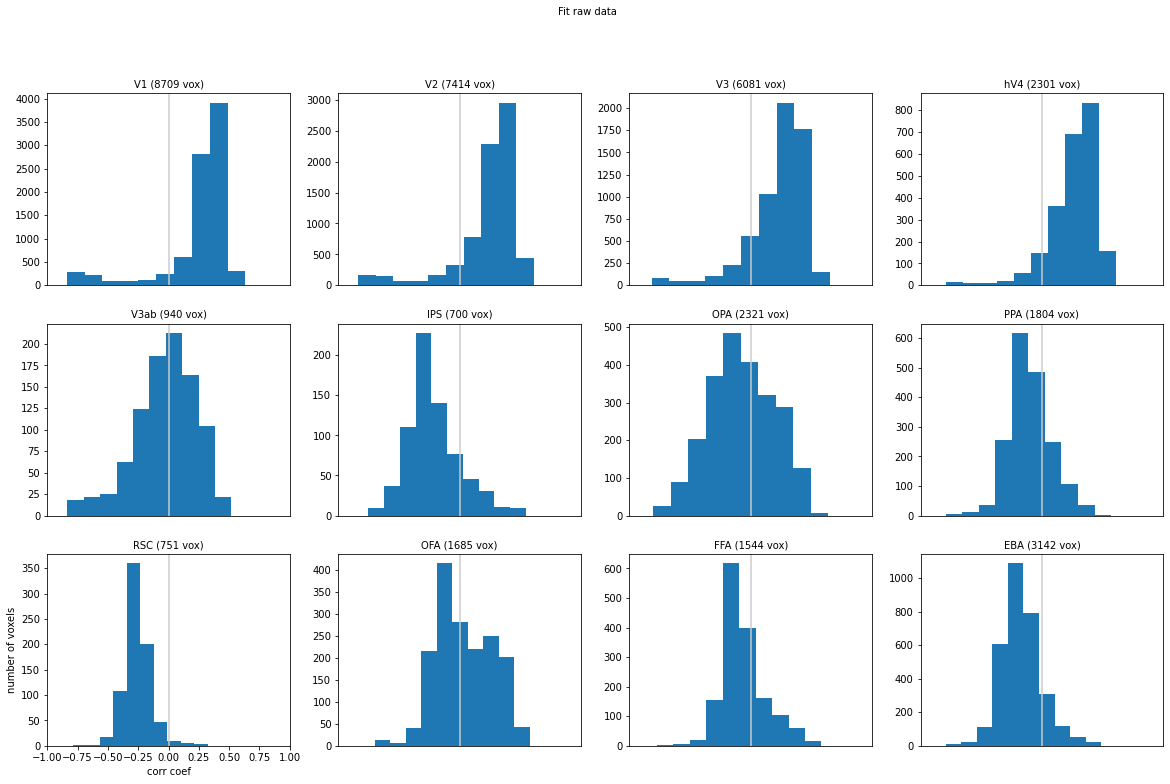

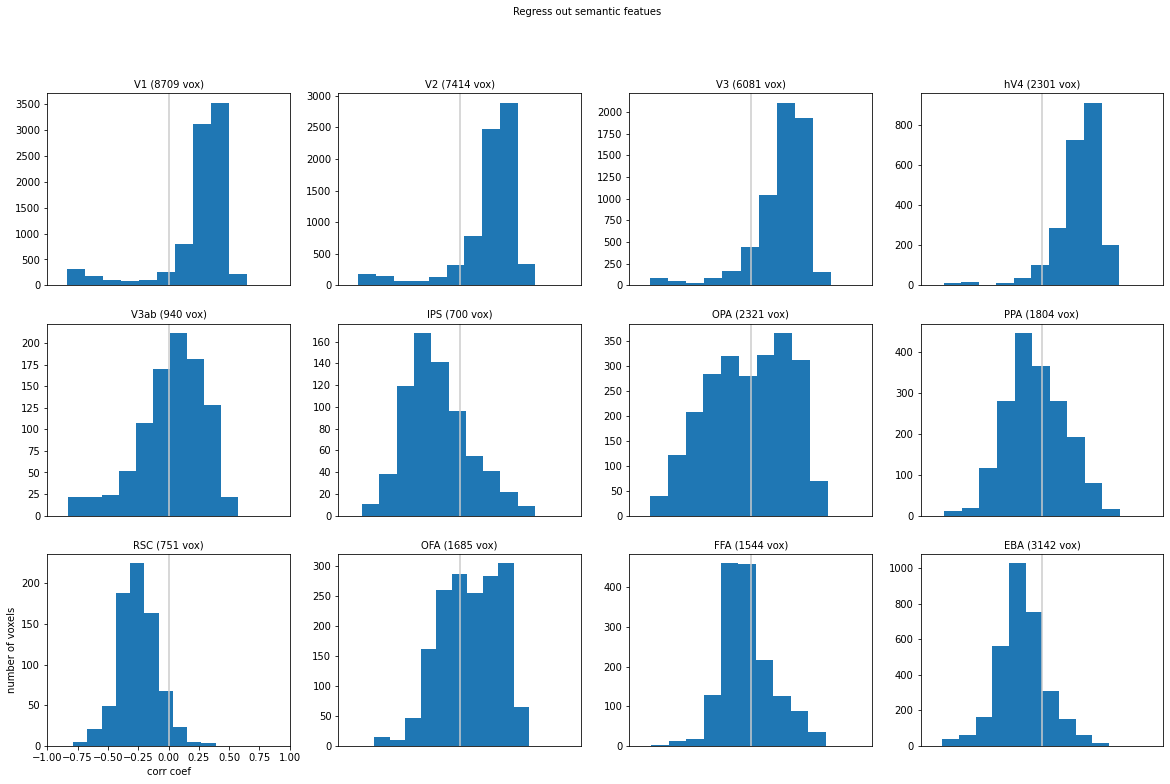

In [43]:
# plotting the distribution of voxel's minimum corr coef, for any orientation

r2_cutoff = 0.01

abv_thresh = (val_r2_1>r2_cutoff) & (val_r2_2>r2_cutoff)



plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.min(mean_orient_corr1[inds_this_roi], axis=1)
    
    plt.hist(vals)
    plt.xlim([-1,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('corr coef')
        plt.ylabel('number of voxels')
    else:
        plt.xticks([]);

    plt.axvline(0,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

    plt.suptitle('Fit raw data')

    
plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.min(mean_orient_corr2[inds_this_roi], axis=1)
    
    plt.hist(vals)
    plt.xlim([-1,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('corr coef')
        plt.ylabel('number of voxels')
    else:
        plt.xticks([]);

    plt.axvline(0,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

    plt.suptitle('Regress out semantic featues')
    